In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
import json
import math

---
## Assignment 1: MUSIC for DOA basic implementation

### 1.1 Generate Data

In [78]:
angles = [20, 60, -30, -35]
freq = [1/2, 1/3, 1/10, 1/5]

thetas = np.array(angles) / 180 * np.pi    # harmonic signal direction 
w = np.array(freq) * np.pi                # harmonic signal frequency
N = 200                                   # snapshots
M = 10                                    # number of microphones
D = np.size(thetas)                        # number of sources
wavelen = 150                             # wave length
d = wavelen / 2                           # distance between mics
var = 0.01                                # variance of noise

A = np.exp(-1j*2*np.pi*d/wavelen* np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
S = 2*np.exp(1j*(np.kron(w, np.arange(N)).reshape((D, N))))
Noise = var*np.random.randn(M, N)
X = np.dot(A, S) + Noise 

### 1.2 Music for DOA Implementation for generated data

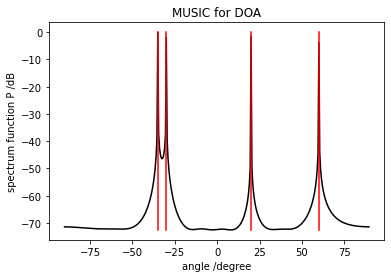

In [79]:
# apply MUSIC
def basic_musicdoa(X, M, D, d, wavelen, resscale):
    # X is M*N array, where N is number of snapshots
    
    theta_range = np.arange(-90, 90, 0.5)
    
    X_normalized = (X.T - X.T.mean(axis=0)).T 
    R = np.dot(X_normalized, X_normalized.conj().T)         # R = XX'
    eig_val, eig_vect = np.linalg.eig(R)         
    ids = np.abs(eig_val).argsort()[:(M-D)] # find the smallest eignvalues
    En = eig_vect[:,ids]
    Ren = np.dot(En, En.conj().T)     # Ren = EnEn'

    L = np.size(theta_range)
    a = np.exp(-1j*2*np.pi*d/wavelen*np.kron(np.arange(M), np.sin(theta_range * np.pi /180)).reshape(M, L))
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i]))) # Pmusic = a(theta)'*En*En'*a(theta)

    # spatial spectrum function
    if resscale=="log":
        Pmusic = 10*np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, theta_range

Pmusic, theta_range = basic_musicdoa(X, M, D, d, wavelen, "log")

# plot
plt.plot(theta_range, Pmusic, '-k')
plt.xlabel('angle /degree')
plt.ylabel('spectrum function P /dB')
plt.title('MUSIC for DOA')
for angle in angles:
        plt.plot((angle,angle),(Pmusic.min(), Pmusic.max()), 'r')
plt.show()

In [95]:
peaks, _ = find_peaks(Pmusic, prominence=10, width=1)
peaks/2-90

array([-35., -30.,  20.,  60.])